In [1]:
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import stats

# Even violins can cry: Specifically-vocal emotional behaviours also drive the perception of emotions in non-vocal music

Data analysis for the smiling violin experiment by Bedoya et al. (2021)\
&copy; JJ Aucouturier, 2020

## Load data

In [2]:
data = pd.read_csv('data/data.csv', index_col=0) 

In [3]:
# make all column names snake case
from stringcase import snakecase
data.columns = map(str.lower, data.columns)
data.columns = map(snakecase, data.columns)

In [4]:
# rename columns 
data.rename(index=str, columns={"rs_valence":'valence',
                                   "rs_arousal":'arousal',
                                   "rt_valence": 'rt_valence',
                                   "rt_arousal":'rt_arousal',
                                   "music_experience":'musician',
                                'gender':'singer_sex',
                               }, inplace=True)

In [5]:
# recode transformations
data.transformation.replace({'vib':'tremor',
                             'angus':'roughness',
                             'NM':'original'}, inplace=True)

In [6]:
# recode transformations
data.sound_type.replace({'Speech':'speech',
                         'Scream':'scream',
                         'Vox':'singing',
                         'Mix':'singing + music',
                         'Mix_violin':'violin + music'}, inplace=True)

In [7]:
# one participant had no ratings for screams: remove
print(data.groupby(['sound_type']).id.nunique())
a = data.groupby(['id']).sound_type.nunique().reset_index()
remove_id = int(a[a.sound_type==4].id)
data = data[~ (data.id == remove_id)]

sound_type
scream             60
singing            61
singing + music    61
speech             61
violin + music     61
Name: id, dtype: int64


## Methods

### Participants

In [8]:
data.id.nunique()

60

In [9]:
data.groupby(['musician']).id.nunique()

musician
musician        29
non-musician    31
Name: id, dtype: int64

In [10]:
data.groupby('sex').id.nunique()

sex
Female    31
Male      29
Name: id, dtype: int64

In [11]:
data.age.describe()

count    31983.000000
mean        23.215708
std          3.264346
min         18.000000
25%         20.000000
50%         23.000000
75%         25.000000
max         31.000000
Name: age, dtype: float64

### Stimuli

In [12]:
data.groupby(['sound_type','transformation']).excerpt.nunique()

sound_type       transformation
scream           down              12
                 original          12
                 roughness         12
                 smile             12
                 tremor            12
                 unsmile           12
                 up                12
singing          down              14
                 original          14
                 roughness         14
                 smile             14
                 tremor            14
                 unsmile           14
                 up                14
singing + music  down              14
                 original          14
                 roughness         14
                 smile             14
                 tremor            14
                 unsmile           14
                 up                14
speech           down              14
                 original          14
                 roughness         14
                 smile             14
                 t

## Results

### Validation for non-musical vocal sounds

In [13]:
variables = ['valence','arousal']
sounds = ['speech','scream']
effects = ['smile','tremor','roughness']
anova_conditions = {'smile':['unsmile','original','smile'], 
                   'tremor':['original','tremor'], 
                   'roughness':['original','roughness']}

In [14]:
import pingouin as pg

for effect in effects:
    for sound in sounds:
        print(sound.capitalize())
        for variable in variables: 
            print(effect.upper()+": "+ variable.capitalize())
            
            effect_condition = anova_conditions[effect][-1]
            control_condition = anova_conditions[effect][0]
            
            # difference in means
            effect_mean = data[(data.sound_type==sound)
                               &(data.transformation==effect_condition)].groupby(['id'])[variable].mean().mean()
            control_mean = data[(data.sound_type==sound)
                                &(data.transformation==control_condition)].groupby(['id'])[variable].mean().mean()
            print('M=%.2f, '%(effect_mean-control_mean), 
                 end='')
            
            # t-test
            t = pg.ttest(x=data[(data.sound_type==sound)
                                           &(data.transformation==effect_condition)].groupby(['id'])[variable].mean(),
                         y=data[(data.sound_type==sound)
                                &(data.transformation==control_condition)].groupby(['id'])[variable].mean(),
                         paired=True)
            print("%s, t(%d)=%.2f, p=%.2e, Cohen's d=%.2f"%(t['CI95%'][0],
                                              t.dof[0],
                                              t['T'][0],
                                              t['p-val'][0],
                                              t['cohen-d'][0]))
            
            #interaction w/ musicians
            aov = pg.mixed_anova(dv=variable,
                                 within='transformation',
                                 between='musician',
                                 subject='id',
                                 data=data[(data.sound_type==sound)
                                           &(data.transformation.isin(anova_conditions[effect]))])
            print("F(%d,%d)=%.2f, p=%.2f, np2=%.2f"%(aov.iloc[2]['DF1'],
                                         aov.iloc[2]['DF2'],
                                         aov.iloc[2]['F'],
                                         aov.iloc[2]['p-unc'],
                                         aov.iloc[2]['np2']))
            print()

Speech
SMILE: Valence
M=1.01, [0.79 1.24], t(59)=9.09, p=8.00e-13, Cohen's d=1.92
F(2,116)=1.23, p=0.30, np2=0.02

SMILE: Arousal
M=1.27, [1.02 1.53], t(59)=10.08, p=1.89e-14, Cohen's d=2.09
F(2,116)=2.40, p=0.10, np2=0.04

Scream
SMILE: Valence
M=0.53, 

c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


[0.26 0.81], t(59)=3.88, p=2.69e-04, Cohen's d=0.77
F(2,116)=0.06, p=0.94, np2=0.00

SMILE: Arousal
M=1.13, [0.86 1.39], t(59)=8.37, p=1.32e-11, Cohen's d=1.68
F(2,116)=0.06, p=0.94, np2=0.00

Speech
TREMOR: Valence
M=-0.19, [-0.28 -0.11], t(59)=-4.55, p=2.77e-05, Cohen's d=0.59
F(1,58)=2.62, p=0.11, np2=0.04

TREMOR: Arousal
M=-0.19, [-0.27 -0.11], t(59)=-4.88, p=8.56e-06, Cohen's d=0.55
F(1,58)=0.03, p=0.87, np2=0.00

Scream
TREMOR: Valence
M=-0.04, [-0.19  0.12], t(59)=-0.45, p=6.55e-01, Cohen's d=0.07
F(1,58)=1.44, p=0.23, np2=0.02

TREMOR: Arousal
M=0.18, [0.07 0.3 ], t(59)=3.14, p=2.60e-03, Cohen's d=0.46
F(1,58)=0.57, p=0.45, np2=0.01

Speech
ROUGHNESS: Valence
M=-0.21, [-0.33 -0.09], t(59)=-3.45, p=1.05e-03, Cohen's d=0.54
F(1,58)=0.79, p=0.38, np2=0.01

ROUGHNESS: Arousal
M=0.05, [-0.04  0.13], t(59)=1.12, p=2.69e-01, Cohen's d=0.14
F(1,58)=1.74, p=0.19, np2=0.03

Scream
ROUGHNESS: Valence
M=-0.71, [-0.89 -0.53], t(59)=-7.78, p=1.28e-10, Cohen's d=1.30
F(1,58)=0.94, p=0.34, np

### Transfer on music

In [15]:
transformations  = ['smile', 'tremor', 'roughness']
affect_dimensions = ['valence', 'arousal']
line_styles      = [':',"-","-","-",':']
markers   = ['v','o','s','d','^']
palette   = ['#1f77b4', '#ff7f0e','#2ca02c', '#d62728', '#9467bd']
factor_order = {'smile':     ['unsmile','original','smile'],
                'tremor':   ['original','tremor'],
                'roughness': ['original','roughness'] }
hue_order    = {'smile':     ['speech','singing','singing + music', 'violin + music','scream'],
                'tremor':   ['speech','singing','singing + music', 'violin + music','scream'],
                'roughness': ['speech','singing','singing + music', 'violin + music','scream']}
marker_types = {'smile':     markers,
                'tremor':     markers,
                'roughness':   markers}
palettes     = {'smile':     palette,
                'tremor':   palette,
                'roughness': palette}
legend_elements = [Line2D([0], [0], marker='v', color='w', label='speech', markerfacecolor=palette[0], markersize=8),
                   Line2D([0], [0], marker='^', color='w', label='scream', markerfacecolor=palette[0], markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='singing', markerfacecolor=palette[1], markersize=8),
                   Line2D([0], [0], marker='s', color='w', label='singing+music', markerfacecolor=palette[2], markersize=8),
                   Line2D([0], [0], marker='d', color='w', label='violin+music', markerfacecolor=palette[3], markersize=8)]

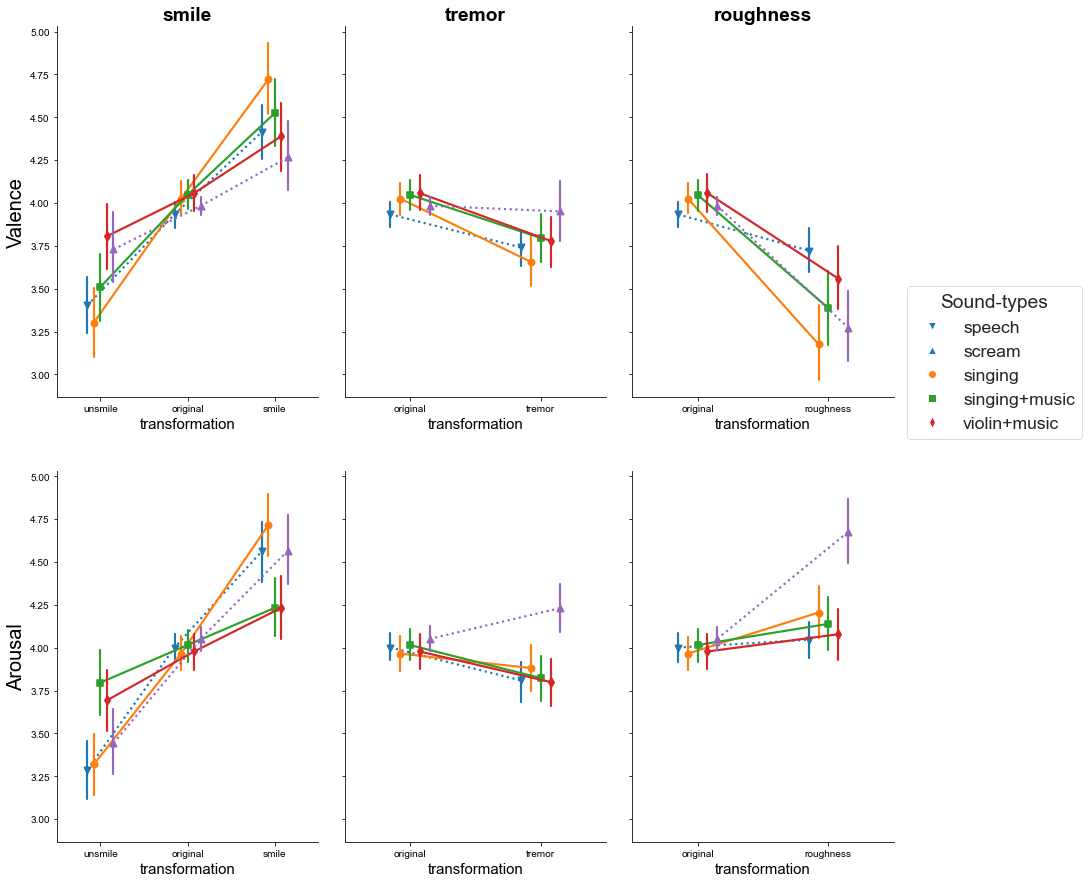

In [16]:
figure, ax = plt.subplots(figsize=[15, 15],
                          ncols=len(transformations),
                          nrows=len(affect_dimensions),
                          sharex=False,
                          sharey=True)
plt.subplots_adjust(wspace =0.1, hspace = 0.2)
with sns.color_palette():
    sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.2})
    sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': ':'})
    for i, dim in enumerate(affect_dimensions):
        for j, transformation in enumerate(transformations):
            sns.pointplot(x = 'transformation',
                          y = dim,
                          ci=95,
                          n_boot=1000,
                          units='id',
                          order = factor_order[transformation],
                          dodge=0.3,
                          markers=marker_types[transformation],
                          linestyles=line_styles,
                          palette=palettes[transformation],
                          hue= 'sound_type',
                          hue_order=hue_order[transformation],
                          data=data[data.transformation.isin(factor_order[transformation])],
                          ax=ax[i,j])
            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)
            ax[i,j].get_legend().set_visible(False)
            plt.setp(ax[i,j].collections, sizes=[40])
            if not ax[i,j].is_first_col():
                ax[i,j].set_ylabel("")
            if ax[i,j].is_last_row() and ax[i,j].is_last_col():
                ax[i,j].get_legend().set_visible(True)
            if i == 0:
                ax[i,j].set_title(transformation, fontweight='bold')
            ax[i,j].xaxis.label.set_size(15)
            
    ax[0,0].set_ylabel("Valence")
    ax[1,0].set_ylabel("Arousal")
    ax[0,0].yaxis.label.set_size(20)
    ax[1,0].yaxis.label.set_size(20)
    
    plt.legend(handles=legend_elements,
               title="Sound-types",
               bbox_to_anchor=(1.05, 1.5),
               loc=2, 
               borderaxespad=0.) #use "$\\bf{}$" for bold
figure.savefig('Figure_2.pdf', format='pdf', dpi=600, transparent=True, bbox_inches = 'tight',
    pad_inches = 0)

In [17]:
variables = ['valence','arousal']
sounds = ['singing','singing + music', 'violin + music']
effects = ['smile','tremor','roughness']
anova_conditions = {'smile':['unsmile','original','smile'], 
                   'tremor':['original','tremor'], 
                   'roughness':['original','roughness']}
interaction_conditions = {'smile':['speech','scream']+sounds, # 5-level analyses
                   'tremor':['speech','scream']+sounds, 
                   'roughness':['speech','scream']+sounds}

In [18]:
import pingouin as pg

for effect in effects:
    for variable in variables: 
        print(effect.upper()+": "+ variable.capitalize())
        for sound in sounds:
            print(sound.capitalize())
                    
            effect_condition = anova_conditions[effect][-1]
            control_condition = anova_conditions[effect][0]
            
            # difference in means
            effect_mean = data[(data.sound_type==sound)
                               &(data.transformation==effect_condition)].groupby(['id'])[variable].mean().mean()
            control_mean = data[(data.sound_type==sound)
                                &(data.transformation==control_condition)].groupby(['id'])[variable].mean().mean()
            print('M=%.2f, '%(effect_mean-control_mean), 
                 end='')
            
            # t-test
            t = pg.ttest(x=data[(data.sound_type==sound)
                                           &(data.transformation==effect_condition)].groupby(['id'])[variable].mean(),
                         y=data[(data.sound_type==sound)
                                &(data.transformation==control_condition)].groupby(['id'])[variable].mean(),
                         paired=True)
            print("%s, t(%d)=%.2f, p=%.2e, Cohen's d=%.2f"%(t['CI95%'][0],
                                              t.dof[0],
                                              t['T'][0],
                                              t['p-val'][0],
                                              t['cohen-d'][0]))
            
        #interaction w/ sound_type
        aov = pg.rm_anova(dv=variable,
                          within=['transformation','sound_type'],
                          subject='id',
                          data=data[(data.transformation.isin(anova_conditions[effect]))
                                   & data.sound_type.isin(interaction_conditions[effect])])
        print("Interaction with sound_type\n F(%d,%d)=%.2f, p=%.2e, np2=%.2f"%(aov.iloc[2]['ddof1'],
                                             aov.iloc[2]['ddof2'],
                                             aov.iloc[2]['F'],
                                             aov.iloc[2]['p-unc'],
                                             aov.iloc[2]['np2']))
        print()

SMILE: Valence
Singing
M=1.45, [1.14 1.75], t(59)=9.56, p=1.37e-13, Cohen's d=2.07
Singing + music
M=1.02, [0.76 1.28], t(59)=7.89, p=8.56e-11, Cohen's d=1.55
Violin + music
M=0.57, [0.35 0.8 ], t(59)=5.13, p=3.43e-06, Cohen's d=0.89
Interaction with sound_type
 F(8,472)=11.58, p=4.60e-15, np2=0.16

SMILE: Arousal
Singing
M=1.41, [1.14 1.67], t(59)=10.50, p=4.05e-15, Cohen's d=2.17
Singing + music
M=0.44, [0.23 0.65], t(59)=4.16, p=1.06e-04, Cohen's d=0.76
Violin + music


c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\pingouin\distribution.py:459: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


M=0.54, [0.33 0.74], t(59)=5.30, p=1.82e-06, Cohen's d=0.93
Interaction with sound_type
 F(8,472)=15.57, p=2.12e-20, np2=0.21

TREMOR: Valence
Singing
M=-0.37, [-0.51 -0.22], t(59)=-5.09, p=3.89e-06, Cohen's d=0.85
Singing + music
M=-0.26, [-0.39 -0.12], t(59)=-3.86, p=2.87e-04, Cohen's d=0.59
Violin + music
M=-0.28, [-0.41 -0.14], t(59)=-3.99, p=1.84e-04, Cohen's d=0.62
Interaction with sound_type
 F(4,236)=3.72, p=5.90e-03, np2=0.06

TREMOR: Arousal
Singing
M=-0.08, [-0.22  0.05], t(59)=-1.20, p=2.37e-01, Cohen's d=0.19
Singing + music
M=-0.19, [-0.3  -0.09], t(59)=-3.80, p=3.41e-04, Cohen's d=0.50
Violin + music
M=-0.19, [-0.31 -0.06], t(59)=-3.04, p=3.48e-03, Cohen's d=0.42
Interaction with sound_type
 F(4,236)=9.37, p=4.78e-07, np2=0.14

ROUGHNESS: Valence
Singing
M=-0.85, [-1.08 -0.61], t(59)=-7.24, p=1.05e-09, Cohen's d=1.33
Singing + music
M=-0.66, [-0.87 -0.45], t(59)=-6.17, p=6.83e-08, Cohen's d=1.05
Violin + music
M=-0.49, [-0.68 -0.31], t(59)=-5.27, p=2.02e-06, Cohen's d=0.

### Interactions with sound type

In [19]:
# construct a new dataframe with effect size
variables = ['valence','arousal']
sounds = ['speech','scream','singing','singing + music', 'violin + music']
effects = ['smile','tremor','roughness']
anova_conditions = {'smile':['unsmile','original','smile'], 
                   'tremor':['original','tremor'], 
                   'roughness':['original','roughness']}

transformation_values = []
sound_type_values = []
variable_values = []
diff_mean_values = []
cohen_d_values = []
p_value_values = []

for effect in effects:
    for sound in sounds:
        for variable in variables: 
            
            effect_condition = anova_conditions[effect][-1]
            control_condition = anova_conditions[effect][0]
            
            # difference in means
            effect_mean = data[(data.sound_type==sound)
                               &(data.transformation==effect_condition)].groupby(['id'])[variable].mean().mean()
            control_mean = data[(data.sound_type==sound)
                                &(data.transformation==control_condition)].groupby(['id'])[variable].mean().mean()
            
            # t-test
            t = pg.ttest(x=data[(data.sound_type==sound)
                                           &(data.transformation==effect_condition)].groupby(['id'])[variable].mean(),
                         y=data[(data.sound_type==sound)
                                &(data.transformation==control_condition)].groupby(['id'])[variable].mean(),
                         paired=True)
            
            # newline: 
            transformation_values += [effect]
            sound_type_values += [sound]
            variable_values += [variable]
            diff_mean_values += [effect_mean-control_mean]
            cohen_d_values += [t['cohen-d'][0]]
            p_value_values +=[t['p-val'][0]]
            
            
effect_size = pd.DataFrame({'transformation' : transformation_values, 
              'sound_type' : sound_type_values, 
              'variable': variable_values,
              'diff_mean':diff_mean_values,
              'cohen_d': cohen_d_values,
            'p_value':p_value_values})

print(effect_size)

   transformation       sound_type variable  diff_mean   cohen_d       p_value
0           smile           speech  valence   1.014286  1.922518  8.002715e-13
1           smile           speech  arousal   1.274206  2.091836  1.894460e-14
2           smile           scream  valence   0.532222  0.773708  2.693458e-04
3           smile           scream  arousal   1.125556  1.681442  1.322879e-11
4           smile          singing  valence   1.445040  2.074999  1.372320e-13
5           smile          singing  arousal   1.406667  2.173648  4.046731e-15
6           smile  singing + music  valence   1.016984  1.554330  8.562479e-11
7           smile  singing + music  arousal   0.440040  0.759015  1.060605e-04
8           smile   violin + music  valence   0.574762  0.887175  3.430453e-06
9           smile   violin + music  arousal   0.536667  0.930757  1.818154e-06
10         tremor           speech  valence  -0.193315  0.589176  2.765258e-05
11         tremor           speech  arousal  -0.1913

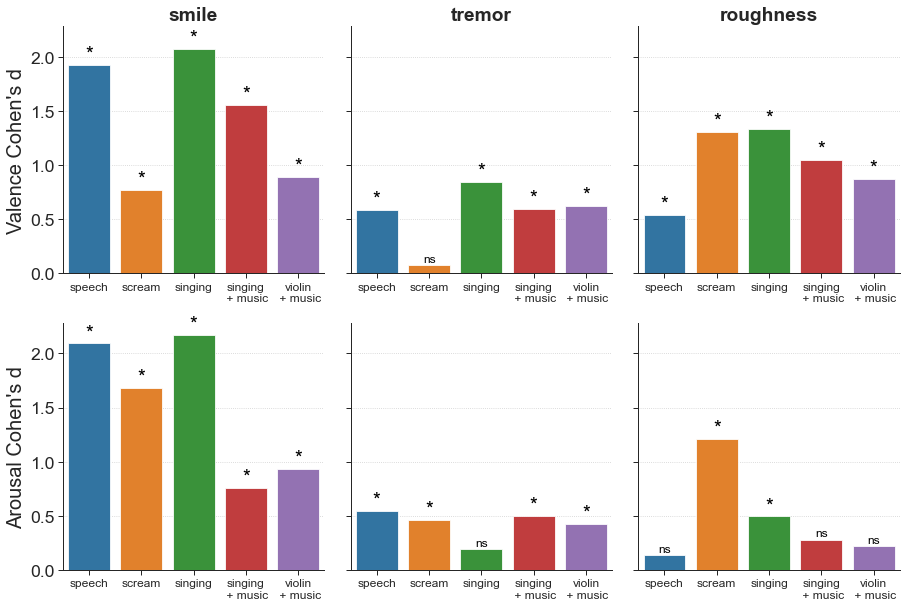

In [20]:
figure, ax = plt.subplots(figsize=[15, 10],
                          ncols=len(transformations),
                          nrows=len(affect_dimensions),
                          sharex=False,
                          sharey=True)
plt.subplots_adjust(wspace =0.1, hspace = 0.2)
with sns.color_palette():
    sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.2})
    sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': ':'})
    for i, dim in enumerate(variables):
        for j, transformation in enumerate(effects):
            g1=sns.barplot(x = 'sound_type',
                           y = 'cohen_d',
                           order = ['speech','scream','singing','singing + music','violin + music'],
                           data = effect_size[(effect_size.variable==dim)
                                             &(effect_size.transformation==transformation)],
                           #palette=['#1f77b4', '#2ca02c', '#ff7f0e','#d62728', '#9467bd',],
                           ax=ax[i,j])
            
            for k,sound in enumerate(['speech','scream','singing','singing + music','violin + music']):
                sig,font = 'ns',12
                if effect_size[(effect_size.variable==dim)
                                         &(effect_size.transformation==transformation)
                                         &(effect_size.sound_type==sound)].p_value.mean()<.05: 
                    sig,font = '*',20
                    
                ax[i,j].text(k,
                             effect_size[(effect_size.variable==dim)
                                         &(effect_size.transformation==transformation)
                                         &(effect_size.sound_type==sound)]['cohen_d'].mean()+0.01,
                             sig, 
                             ha='center',
                             va='bottom',
                             color='k',
                            fontsize=font)
            
            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)
            #ax[i,j].get_legend().set_visible(False)
            plt.setp(ax[i,j].collections, sizes=[40])
            if not ax[i,j].is_first_col():
                ax[i,j].set_ylabel("")
            #if ax[i,j].is_last_row() and ax[i,j].is_last_col():
            #    ax[i,j].get_legend().set_visible(True)
            if i == 0:
                ax[i,j].set_title(transformation, fontweight='bold')
            ax[i,j].set_xlabel('')
            ax[i,j].set_xticklabels(['speech','scream','singing','singing\n + music','violin\n + music'],
                                   fontsize=12)
                        
    ax[1,0].yaxis.label.set_size(20)
    ax[0,0].set_ylabel("Valence Cohen's d")
    ax[1,0].set_ylabel("Arousal Cohen's d")
    ax[0,0].yaxis.label.set_size(20)
   


In [21]:
# get mean difference per participant
transformations = ['smile','unsmile','tremor','roughness','original']

# average ratings per participants
mean_data = data[data.transformation.isin(transformations)].groupby(['id',
                                                      'musician',
                                                      'transformation',
                                                      'sound_type'])[['valence','arousal']].mean().reset_index()

# join each with average original and average unsmile ratings
original_data=mean_data[mean_data.transformation=='original'][['id','sound_type','valence','arousal']].set_index(['id','sound_type'])
unsmile_data=mean_data[mean_data.transformation=='unsmile'][['id','sound_type','valence','arousal']].set_index(['id','sound_type'])
d = mean_data.join(original_data,
                   on=['id','sound_type'],
                   rsuffix='_original').join(unsmile_data,
                                             on=['id','sound_type'],
                                             rsuffix='_unsmile')

# for effects tremor and effort, normalize by original
d.loc[d.transformation.isin(['original','tremor','roughness']),'norm_valence'] = d.valence - d.valence_original
d.loc[d.transformation.isin(['original','tremor','roughness']),'norm_arousal'] = d.arousal - d.arousal_original
# for effect smile, normalize by unsmile
d.loc[d.transformation.isin(['smile']),'norm_valence'] = d.valence - d.valence_unsmile
d.loc[d.transformation.isin(['smile']),'norm_arousal'] = d.arousal - d.arousal_unsmile



In [22]:
#interaction w/ sound_type
effects = ['smile','tremor','roughness']
variables = ['norm_valence','norm_arousal']
anova_conditions = {'smile':['speech','scream','singing','singing + music', 'violin + music'], 
                   'tremor':['speech','scream','singing','singing + music', 'violin + music'], 
                   'roughness':['speech','scream','singing','singing + music', 'violin + music']}

for effect in effects:
    print(effect.upper())
    for variable in variables: 
        print(variable)
        aov = pg.rm_anova(dv=variable,
                  within=['sound_type'],
                  subject='id',
                  data=d[(d.transformation==effect)&(d.sound_type.isin(anova_conditions[effect]))])
        print("F(%d,%d)=%.2f, p=%.2e, np2=%.2f"%(aov.iloc[0]['ddof1'],
                                             aov.iloc[0]['ddof2'],
                                             aov.iloc[0]['F'],
                                             aov.iloc[0]['p-unc'],
                                             aov.iloc[0]['np2']))
        post_hocs = pg.pairwise_ttests(dv=variable,
                  within=['sound_type'],
                  subject='id',
                data=d[d.transformation==effect]).round(3)
        
        for indew,row in post_hocs.iterrows(): 
            
            sound_type_1 = row['A']
            d_1 = float(effect_size[(effect_size.transformation==effect)
                                    &(effect_size.sound_type==sound_type_1)
                                    &(effect_size['variable']==variable.split('_')[1])].cohen_d)
            sound_type_2 = row['B']
            d_2 = float(effect_size[(effect_size.transformation==effect)
                                    &(effect_size.sound_type==sound_type_2)
                                    &(effect_size['variable']==variable.split('_')[1])].cohen_d)
            print('%s (d=%.2f) - %s (d=%.2f): t(%d)=%.2f, p=%e'%(sound_type_1,d_1,
                                                             sound_type_2, d_2,
                                                             row['dof'],row['T'],row['p-unc']))        
        

SMILE
norm_valence
F(4,236)=14.93, p=6.83e-11, np2=0.20
scream (d=0.77) - singing (d=2.07): t(59)=-5.44, p=0.000000e+00
scream (d=0.77) - singing + music (d=1.55): t(59)=-2.98, p=4.000000e-03
scream (d=0.77) - speech (d=1.92): t(59)=-3.35, p=1.000000e-03
scream (d=0.77) - violin + music (d=0.89): t(59)=-0.28, p=7.780000e-01
singing (d=2.07) - singing + music (d=1.55): t(59)=4.17, p=0.000000e+00
singing (d=2.07) - speech (d=1.92): t(59)=3.23, p=2.000000e-03
singing (d=2.07) - violin + music (d=0.89): t(59)=6.33, p=0.000000e+00
singing + music (d=1.55) - speech (d=1.92): t(59)=0.02, p=9.830000e-01
singing + music (d=1.55) - violin + music (d=0.89): t(59)=4.23, p=0.000000e+00
speech (d=1.92) - violin + music (d=0.89): t(59)=3.41, p=1.000000e-03
norm_arousal
F(4,236)=21.11, p=6.81e-15, np2=0.26
scream (d=1.68) - singing (d=2.17): t(59)=-2.00, p=5.100000e-02
scream (d=1.68) - singing + music (d=0.76): t(59)=4.48, p=0.000000e+00
scream (d=1.68) - speech (d=2.09): t(59)=-1.21, p=2.330000e-01


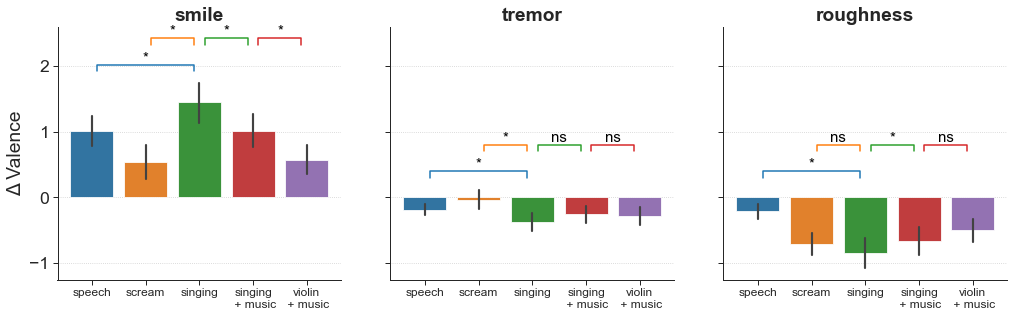

In [23]:
order=['speech','scream','singing','singing + music','violin + music']

sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.2})
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': ':'})
    
g1 = sns.catplot(data=d,
              x='sound_type',
            order=order,
            col='transformation',
            col_order=['smile','tremor','roughness'],
            y='norm_valence',
            dodge=True,
           kind='bar', 
                legend_out=False)

g1.axes[0,0].set_ylabel(u'\u0394 Valence');
for index, transformation in enumerate(['smile','tremor','roughness']):
    g1.axes[0,index].set_xticklabels(['speech','scream','singing','singing\n + music','violin\n + music'],
                                   fontsize=12);
    g1.axes[0,index].set_title(transformation, fontweight='bold')
    g1.axes[0,index].set_xlabel('')
    
    # add stat annotations    
    post_hocs = pg.pairwise_ttests(dv='norm_valence',
                               within=['sound_type'],
                               subject='id',
                               data=d[d.transformation==transformation]).round(3)
    
    pairs = [['speech','singing'],
            ['scream','singing'],
            ['singing','singing + music'],
            ['singing + music','violin + music']]
    
    y_mean = d[(d.transformation==transformation)]['norm_valence'].mean().max()
    
    for pair_index, pair in enumerate(pairs): 
        #print(index,pair)
        # location in graph
        x1 = order.index(pair[0])+0.1
        x2 = order.index(pair[1])-0.1
        #mean_y = d[(d.transformation==transformation)&
        #         (d.sound_type.isin(pair))]['norm_valence'].mean().max()
        y = y_mean*(y_mean>0) + 0.7*(y_mean>0) + 0.3+ (pair_index>0)*0.4
        h = 0.1
        h_label = h
        
        # significance
        p = float(post_hocs.loc[((post_hocs.A==pair[0])&(post_hocs.B==pair[1]))|((post_hocs.A==pair[1])&(post_hocs.B==pair[0])),'p-unc'])
        
        if p < 0.05:
            text = '*'
        else:
            text = 'ns'    
                    
        g1.axes[0,index].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5)
        g1.axes[0,index].text((x1+x2)*.5, y+h_label, text, ha='center', va='bottom', color='k', fontsize=15)

    
g1.savefig('sound_type_valence.pdf', format='pdf', dpi=1000, transparent=True)


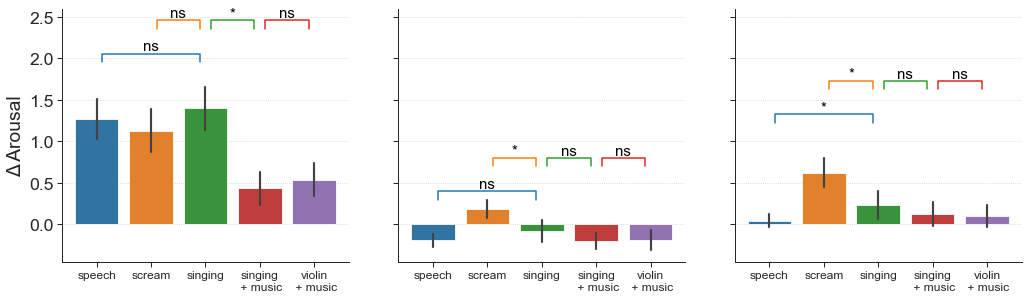

In [24]:
order=['speech','scream','singing','singing + music','violin + music']

sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.2})
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': ':'})
    
g1 = sns.catplot(data=d,
              x='sound_type',
            order=order,
            col='transformation',
            col_order=['smile','tremor','roughness'],
            y='norm_arousal',
            dodge=True,
           kind='bar', 
                legend_out=False)

g1.axes[0,0].set_ylabel(u'\u0394 Arousal');
for index, transformation in enumerate(['smile','tremor','roughness']):
    g1.axes[0,index].set_xticklabels(['speech','scream','singing','singing\n + music','violin\n + music'],
                                   fontsize=12);
    g1.axes[0,index].set_title('')
    
    g1.axes[0,index].set_xlabel('')
    
    # add stat annotations    
    post_hocs = pg.pairwise_ttests(dv='norm_arousal',
                               within=['sound_type'],
                               subject='id',
                               data=d[d.transformation==transformation]).round(3)
    
    pairs = [['speech','singing'],
            ['scream','singing'],
            ['singing','singing + music'],
            ['singing + music','violin + music']]
    
    y_mean = d[(d.transformation==transformation)]['norm_arousal'].mean().max()
    
    for pair_index, pair in enumerate(pairs): 
        # location in graph
        x1 = order.index(pair[0])+0.1
        x2 = order.index(pair[1])-0.1
        y = y_mean*(y_mean>0) + (y_mean>0)*0.7 + 0.3 + (pair_index>0)*0.4
        h = 0.1
        h_label = h
        # significance
        p = float(post_hocs.loc[((post_hocs.A==pair[0])&(post_hocs.B==pair[1]))|((post_hocs.A==pair[1])&(post_hocs.B==pair[0])),'p-unc'])
        if p < 0.05:
            text = '*'
        else:
            text = 'ns'    
                    
        g1.axes[0,index].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5)
        g1.axes[0,index].text((x1+x2)*.5, y+h_label, text, ha='center', va='bottom', color='k', fontsize=15)

    
g1.savefig('sound_type_arousal.pdf', format='pdf', dpi=1000, transparent=True)


### Effect of musicianship

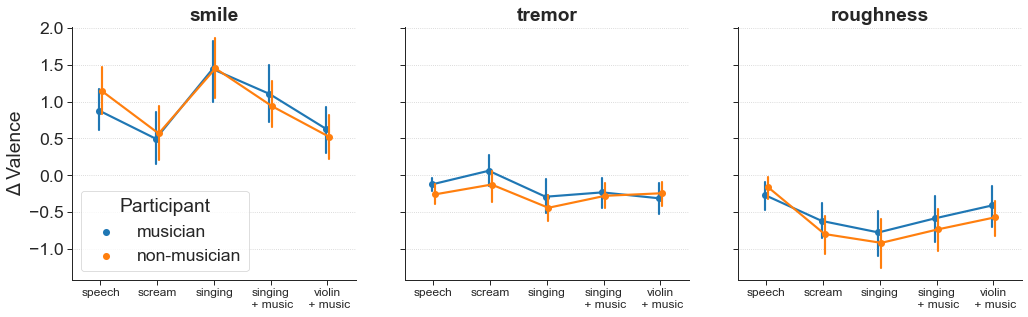

In [25]:
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.2})
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': ':'})
    
g1 = sns.catplot(data=d,
              x='sound_type',
            order=['speech','scream','singing','singing + music','violin + music'],
            col='transformation',
            col_order=['smile','tremor','roughness'],
            y='norm_valence',
              hue='musician',
            dodge=True,
           kind='point', 
                legend_out=False)

g1.axes[0,0].set_ylabel(u'\u0394 Valence');
for index, transformation in enumerate(['smile','tremor','roughness']):
    g1.axes[0,index].set_xticklabels(['speech','scream','singing','singing\n + music','violin\n + music'],
                                   fontsize=12);
    g1.axes[0,index].set_title(transformation, fontweight='bold')
    g1.axes[0,index].set_xlabel('')

g1.axes[0,0].legend(title='Participant')
    
g1.savefig('musician_valence.pdf', format='pdf', dpi=1000, transparent=True)


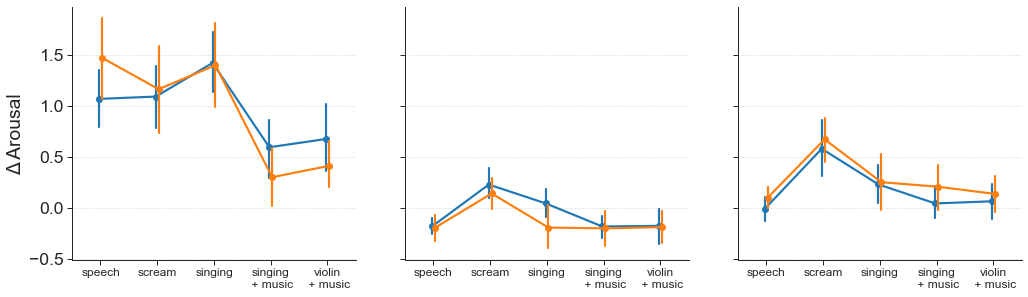

In [26]:
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.2})
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': ':'})
    
g1 = sns.catplot(data=d,
              x='sound_type',
            order=['speech','scream','singing','singing + music','violin + music'],
            col='transformation',
            col_order=['smile','tremor','roughness'],
            y='norm_arousal',
              hue='musician',
            dodge=True,
           kind='point', 
                legend=False)

g1.axes[0,0].set_ylabel(u'\u0394 Arousal');
for index, transformation in enumerate(['smile','tremor','roughness']):
    g1.axes[0,index].set_xticklabels(['speech','scream','singing','singing\n + music','violin\n + music'],
                                   fontsize=12);
    g1.axes[0,index].set_title(transformation, fontweight='bold')
    g1.axes[0,index].set_xlabel('')
    g1.axes[0,index].set_title('')
    #g1.axes[0,index].get_legend().set_visible(False)
    
g1.savefig('musician_arousal.pdf', format='pdf', dpi=1000, transparent=True)


In [27]:
#interaction with musicianship
for effect in ['smile','tremor','roughness']:
    for variable in ['norm_valence','norm_arousal']: 
        print(effect.upper()+": "+ variable.capitalize())
            
        aov = pg.mixed_anova(dv=variable,
               within='sound_type',
               between='musician',
               subject='id',
               data=d[d.transformation==effect])
        print("Interaction with musicianship\n F(%d,%d)=%.2f, p=%.2e, np2=%.2f"%(aov.iloc[2]['DF1'],
                                             aov.iloc[2]['DF2'],
                                             aov.iloc[2]['F'],
                                             aov.iloc[2]['p-unc'],
                                             aov.iloc[2]['np2']))
        print()
        
        


SMILE: Norm_valence
Interaction with musicianship
 F(4,232)=0.75, p=5.60e-01, np2=0.01

SMILE: Norm_arousal
Interaction with musicianship
 F(4,232)=2.24, p=6.60e-02, np2=0.04

TREMOR: Norm_valence
Interaction with musicianship
 F(4,232)=0.63, p=6.38e-01, np2=0.01

TREMOR: Norm_arousal
Interaction with musicianship
 F(4,232)=0.84, p=4.99e-01, np2=0.01

ROUGHNESS: Norm_valence
Interaction with musicianship
 F(4,232)=0.77, p=5.48e-01, np2=0.01

ROUGHNESS: Norm_arousal
Interaction with musicianship
 F(4,232)=0.16, p=9.57e-01, np2=0.00

